In [1]:
import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
import re
import csv
import numpy as np

In [3]:
def load_data(path):
    with open(path) as file:
        reader = csv.reader(file, delimiter=',')
        # get header
        header = next(reader)
        data = np.asarray([[value for value in row] for row in reader])
    return header, data

In [4]:
header, data = load_data("data/training.csv")

In [5]:
print(data.shape)

(1546454, 16)


# Data preprocessing

### Remove features

In [6]:
def print_sample(header, data):
    for i, (feature, value) in enumerate(zip(header, data[0])):
        print("({:^2d}) {:30} : {}".format(i, feature, value))

In [7]:
def print_feature(header, data, max_feature=5):
    for n_feature, feature in enumerate(data.T):
        values, counts = np.unique(feature, return_counts=True)
        counts_values = sorted(zip(counts, values), reverse=True)
        print("-" * 50)
        print("{}".format(header[n_feature]))
        print("-" * 50)
        for i, (v, c) in enumerate(counts_values):
            if i > max_feature:
                break
            print("{:10} : {:10} ({:5.1%})".format(c, v, v / data.shape[0]))

In [8]:
print_feature(header, data)

--------------------------------------------------
Date/Hour
--------------------------------------------------
2016-08-31 23:00 :        182 ( 0.0%)
2016-08-31 22:00 :        182 ( 0.0%)
2016-08-31 21:00 :        182 ( 0.0%)
2016-08-31 20:00 :        182 ( 0.0%)
2016-08-31 19:00 :        182 ( 0.0%)
2016-08-31 18:00 :        182 ( 0.0%)
--------------------------------------------------
Temperature (°C)
--------------------------------------------------
19,0       :      11830 ( 0.8%)
21,5       :      11648 ( 0.8%)
21,1       :      11648 ( 0.8%)
21,0       :      11648 ( 0.8%)
19,5       :      11648 ( 0.8%)
20,2       :      11102 ( 0.7%)
--------------------------------------------------
Drew point (°C)
--------------------------------------------------
16,2       :      13286 ( 0.9%)
16,0       :      13286 ( 0.9%)
15,3       :      12740 ( 0.8%)
14,5       :      12194 ( 0.8%)
17,7       :      11830 ( 0.8%)
15,1       :      11830 ( 0.8%)
---------------------------------------

We can remove the feature without values in over 50% of samples. We decide to keep Weather as it is discrete and we can easily replace it with a one-hot vector. We also need to remove Withdrawals that is not available in test data.

In [9]:
data = np.delete(data, [7, 9, 10, 14], 1)
header = np.delete(header, [7, 9, 10, 14])

### Convert Date (feature 0)

In [10]:
def convert_date(data, index):
    new_data = []
    for i, d in enumerate(data):
        new_data.append(
            re.split('-| |:|', d[index])[:-1] + list(d[index + 1:]))
    return np.asarray(new_data)

In [11]:
index_date = 0
data = convert_date(data, index_date)
header = ["Year", "Month", "Day", "Hour"] + list(header[index_date + 1:])

### Convert Weather (feature 12)

In [12]:
def convert_weather(data, weather, index):
    N = len(weather)
    new_data = []
    for i, d in enumerate(data):
        new_data.append(
            list(d[:index]) +
            [1 if w.lower() in d[index].lower() else 0
             for w in weather] + list(d[index + 1:]))
    return np.asarray(new_data)

In [13]:
index_weather = 11
set(l for s in set(data.T[index_weather]) for l in s.split(","))

{'',
 'Averses de neige',
 'Averses de pluie',
 'Averses de pluie forte',
 'Averses de pluie modérées',
 'Brouillard',
 'Bruine',
 'Dégagé',
 'Généralement dégagé',
 'Généralement nuageux',
 'ND',
 'Neige',
 'Nuageux',
 'Orages',
 'Pluie',
 'Pluie forte',
 'Pluie modérée'}

In [14]:
weather = [
    'Orages', 'Brouillard', 'Bruine', 'Généralement dégagé',
    'Généralement nuageux', 'Pluie', 'Pluie modérée', 'Pluie forte', 'Dégagé',
    'Nuageux', 'Neige'
]
data = convert_weather(data, weather, index_weather)
header = list(header[:index_weather]) + weather + list(
    header[index_weather + 1:])

### Convert data type to float

In [15]:
# samples with at least one missing value
missing = [d for d in data if '' in d]
print(len(missing))

# number of class 1 with missing value
print(sum(['1' in d[-1] for d in missing]))

2184
174


Let's remove the samples with missing values as only one hundred have label 1.

In [16]:
def convert_type(data):
    return np.asarray(
        [[float(v.replace(",", ".")) for v in d] for d in data if "" not in d])

In [17]:
data = convert_type(data)

In [18]:
print_sample(header, data)

(0 ) Year                           : 2015.0
(1 ) Month                          : 6.0
(2 ) Day                            : 29.0
(3 ) Hour                           : 11.0
(4 ) Temperature (°C)               : 17.6
(5 ) Drew point (°C)                : 11.5
(6 ) Relativite humidity (%)        : 67.0
(7 ) wind direction (10s deg)       : 31.0
(8 ) Wind speed (km/h)              : 13.0
(9 ) Visibility (km)                : 24.1
(10) Pressure at the station (kPa)  : 100.53
(11) Orages                         : 0.0
(12) Brouillard                     : 0.0
(13) Bruine                         : 0.0
(14) Généralement dégagé            : 0.0
(15) Généralement nuageux           : 0.0
(16) Pluie                          : 0.0
(17) Pluie modérée                  : 0.0
(18) Pluie forte                    : 0.0
(19) Dégagé                         : 0.0
(20) Nuageux                        : 0.0
(21) Neige                          : 0.0
(22) Public Holiday                 : 0.0
(23) Station Code   

In [19]:
print(data.shape)

(1544270, 25)


# Data analysis & visualization

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
def plot_features(header, data):
    cols = 4
    n = data.shape[1] // cols + 1
    fig, ax = plt.subplots(nrows=n, ncols=cols, figsize=(cols * 6, n * 6))
    for i, (name, feature) in enumerate(zip(header, data.T)):
        ax[i // cols, i % cols].hist(feature)
        ax[i // cols, i % cols].set_title(name)
    plt.show()

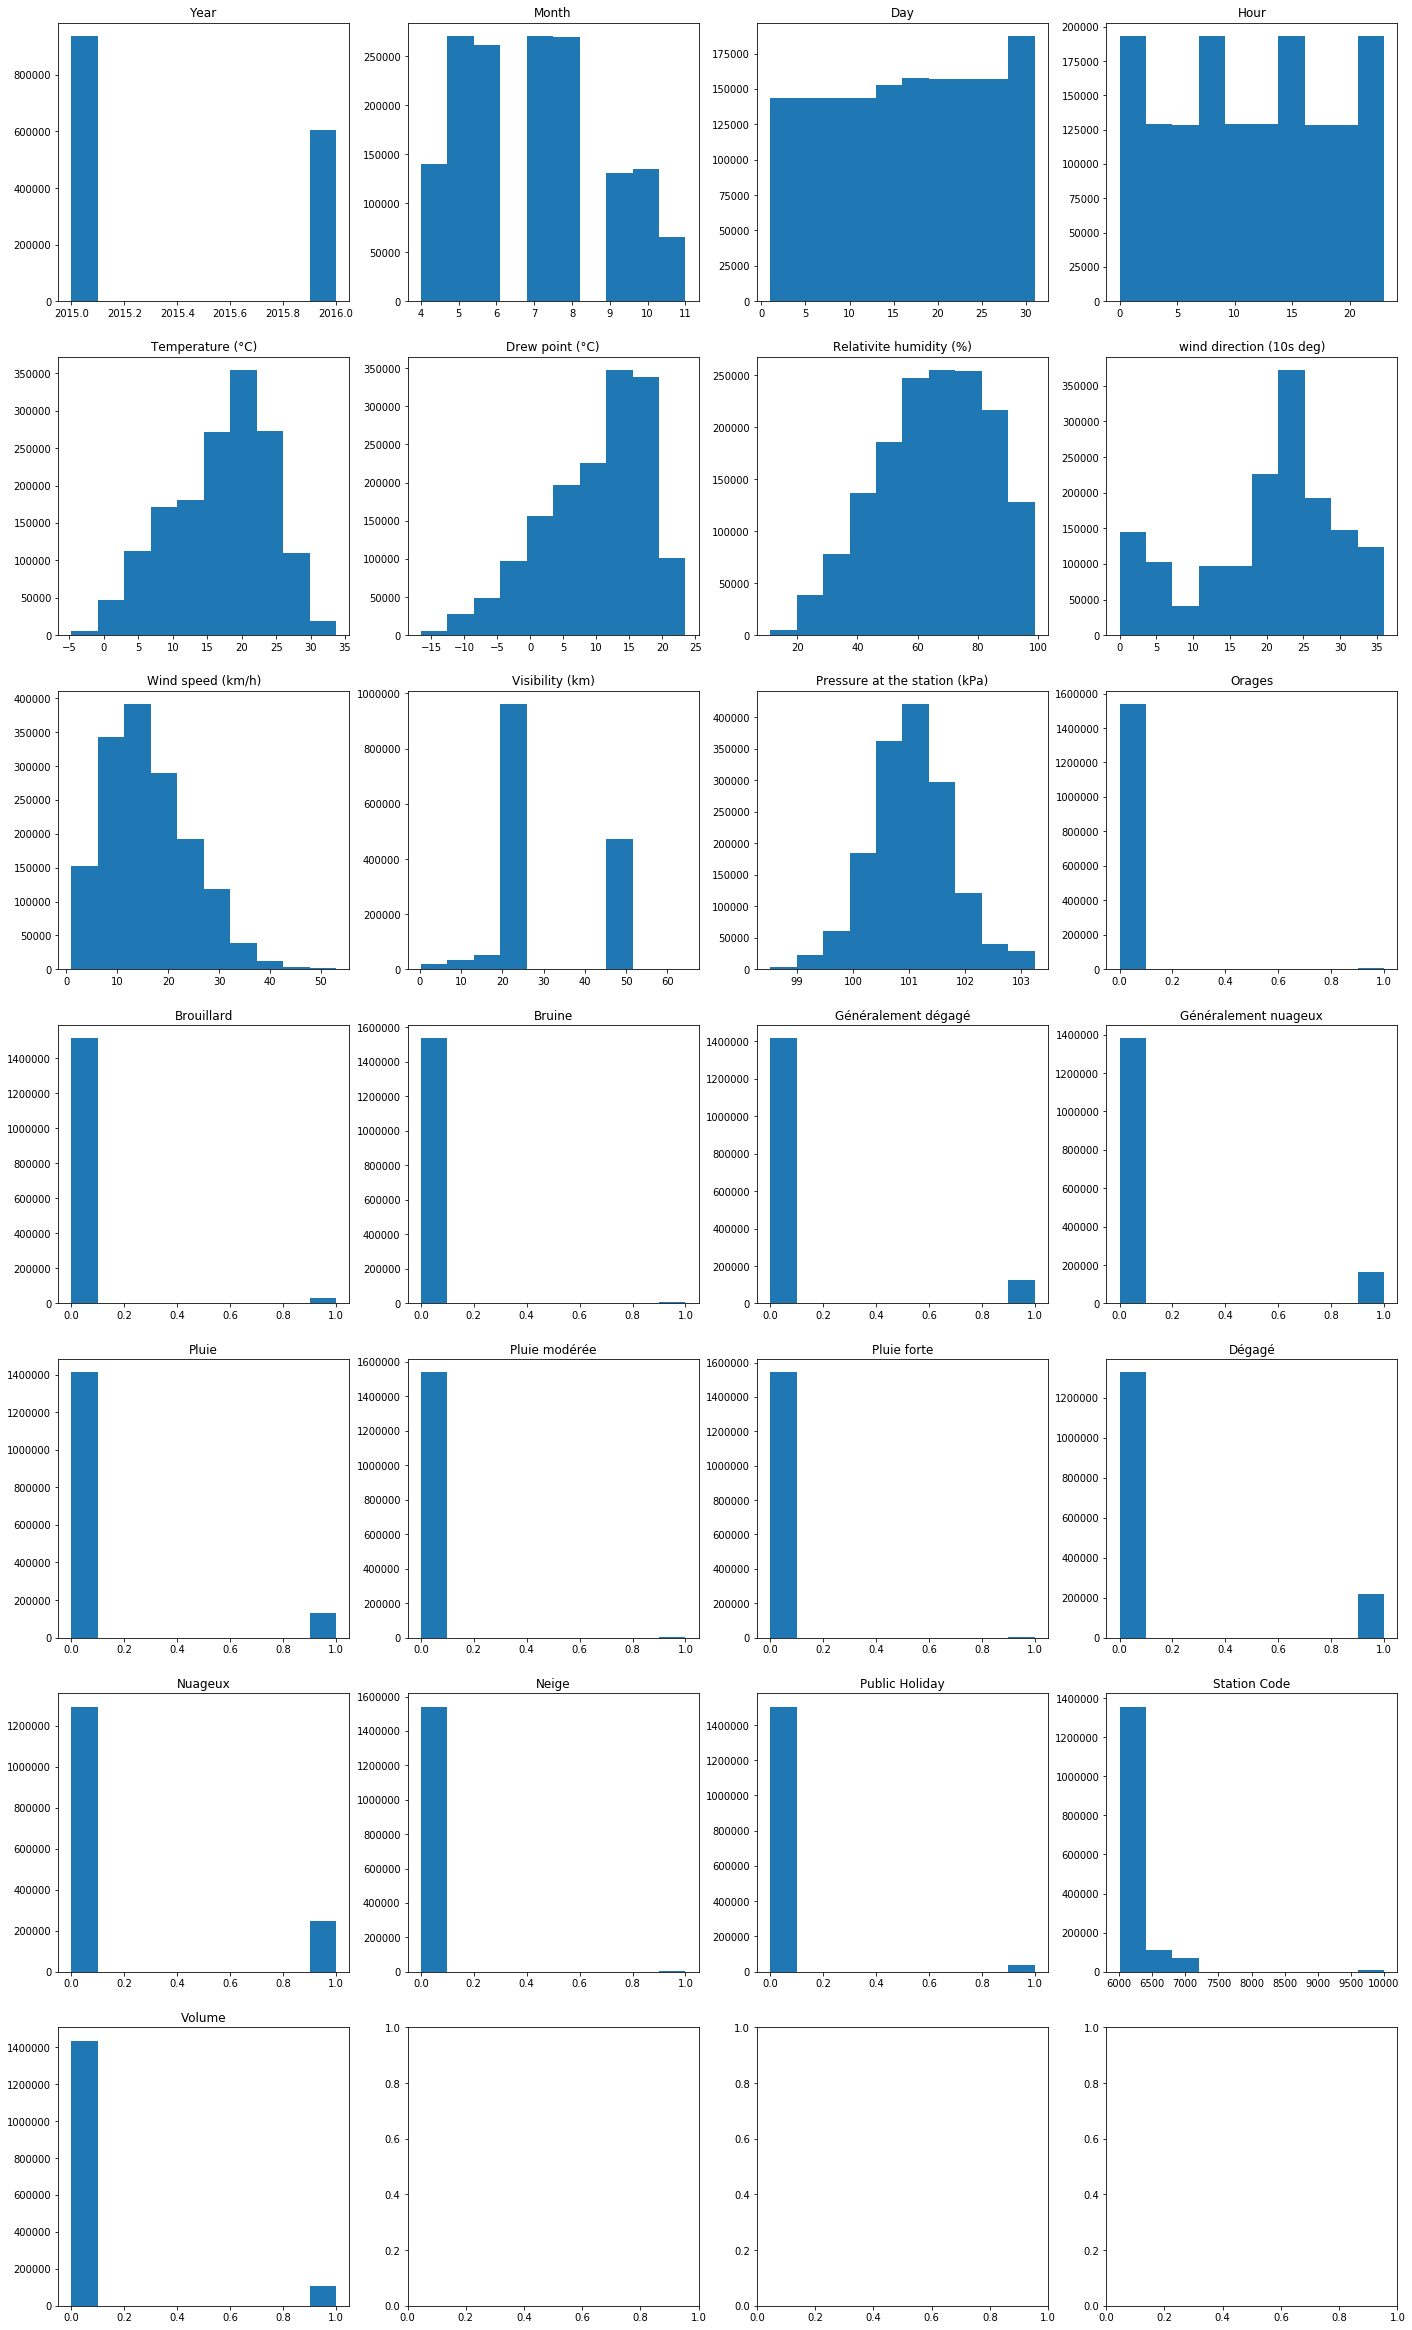

In [22]:
plot_features(header, data)

# Logistic regression

In [47]:
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [48]:
x, y = data[:, :-1], data[:, -1]

In [49]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [50]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, stratify=y)

In [51]:
for i in range(1, 10):
    model = LogisticRegression(max_iter=9999, class_weight={0: 1, 1: i})
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(i)
    print(recall_score(y_test, y_pred))
    print(precision_score(y_test, y_pred))
    print(f1_score(y_test, y_pred))

1
0.0
0.0
0.0


/home/quentin/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/quentin/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2
0.03818648574310076
0.3247563352826511
0.06833750358915461
3
0.16406894654808837
0.2874698795180723
0.20890730796170906
4
0.28614651141468783
0.24643689052074697
0.2648113187535796
5
0.3965801778674246
0.22558018252933507
0.2875806129911575
6
0.4795085724763913
0.20883662427376365
0.2909556195324126
7
0.5484092784450353
0.19570729792072242
0.2884701173123063
8
0.6072247180709636
0.18574974407875364
0.2844778523489933
9
0.6491244155129733
0.17673048600883653
0.27782137811960445
